# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  






In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import nltk
import gensim

from sklearn import metrics

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator

SEED = 42
np.random.seed(SEED)

Токенайзер обычный

In [2]:
from tqdm import tqdm_notebook as tqdm

from nltk.tokenize import wordpunct_tokenize
def tokenizer(text): # create a tokenizer function
    return [tok for tok in wordpunct_tokenize(text.lower()) if tok.isalpha()]            

In [4]:
data = pd.read_csv('./imdb_master.csv', encoding='utf-8', index_col=0)

In [5]:
data.head()

,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [6]:
data.shape

(100000, 4)

In [6]:
tokenizer('А, б, !!!')

['а', 'б']

Разделим выборку на трейн и тест, чтобы загружать просто из файлов

In [7]:
train = data[data['type']=='train']
train.shape

(75000, 4)

In [8]:
test = data[data['type']=='test']
test.shape

(25000, 4)

In [9]:
train[['review','label']].to_csv('train.csv', index=False)

In [10]:
test[['review','label']].to_csv('test.csv', index=False)

In [11]:
data['label'].value_counts()

unsup    50000
neg      25000
pos      25000
Name: label, dtype: int64

Маленький кусочек просто данных, чтобы проверять корректность работы функций (все равно что, протсо по форме подходило чтобы)

In [4]:
from sklearn.model_selection import train_test_split

data, _ = train_test_split(data, train_size=0.05, random_state=23)

data[['review','label']].to_csv('train_small.csv', index=False)

## Datasets

In [3]:
classes={
    'neg':0,
    'unsup':1,
    'pos':2
}

TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=nltk.corpus.stopwords.words('english'))
LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])

dataset = TabularDataset('train.csv', format='csv', 
                         fields=[('text', TEXT),('label', LABEL)], 
                         skip_header=True)

In [4]:
test = TabularDataset('test.csv', format='csv', 
                         fields=[('text', TEXT),('label', LABEL)], 
                         skip_header=True)

In [5]:
LABEL.build_vocab(dataset)

In [17]:
TEXT.build_vocab(dataset, min_freq=10, vectors="glove.6B.100d")
len(TEXT.vocab.itos)

34027

In [18]:
weights_matrix = TEXT.vocab.vectors

In [19]:
weights_matrix.shape

torch.Size([34027, 100])

In [20]:
TEXT.vocab.itos[8]

'good'

#### Embeddings

Неудачный опыт с эмбедингами вики (почему-то лосс был очень быльшим, после перехода на глов стало хорошо, видимо, где-то была проблема)

In [ ]:
#matrix_len = len(TEXT.vocab.itos)
#weights_matrix = np.random.randn(matrix_len, 300)
#words = 0

#D = {value:key for key, value in enumerate(TEXT.vocab.itos)}

#with open ('wiki-news-300d-1M.vec', 'r') as f:
#    for line in f:
#        word = line.split()[0]
#        vector = line.split()[1:]
#        break
#    for line in tqdm(f, total=999994):
#        word = line.split()[0]
#        vector = [float(i) for i in line.split()[1:]]
#        if word in D:
#            weights_matrix[D[word]] = vector

#weights_matrix = tt.FloatTensor(weights_matrix)

делим на трейн и валидацию

In [21]:
train, valid = dataset.split(0.7, stratified=True)

In [22]:
batch_size = 32
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text)
)

## Model 1

In [23]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, kernels, weights_matrix):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(weights_matrix)
        self.embedding.requires_grad = False
        
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x

In [28]:
from sklearn.base import BaseEstimator, ClassifierMixin
class Estimator(BaseEstimator, ClassifierMixin):
    """
    Logistic Regression estimator coping interface from scikit-learn
    """
    def __init__(self, MyModel, n_epochs, vocab_size, embed_size, hidden_size, kernels, weights_matrix, batch_size=32):
        self.model_nn = MyModel(len(TEXT.vocab.itos),
                        embed_size=embed_size,
                        hidden_size=hidden_size,
                        kernels=kernels,
                        weights_matrix=weights_matrix
                       )
        self.batch_size = batch_size
        self.lr = []
        self.loss = []
        self.valid = []
        self.n_epochs = n_epochs
        
        
    def fit(self, train_iterator, valid_iterator, lr=0.1):
        tt.cuda.empty_cache()
        optimizer = tt.optim.Adam(self.model_nn.parameters(), lr=lr)
        scheduler = tt.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
        criterion = nn.CrossEntropyLoss()
        early_k = 0
        min_loss = float('inf')
        for i in tqdm(range(self.n_epochs), desc='Epoch'):
            loss = 0
            for batch in tqdm(train_iterator, leave=False, desc='Train'):
                pred = self.model_nn.forward(batch.text[0])
                l = criterion(pred, batch.label)
                loss += l.item()
                optimizer.zero_grad()
                l.backward()
                optimizer.step()
            train_avg =  loss / len(train_iterator)
            self.loss.append(train_avg)
            self.lr.append(optimizer.param_groups[0]['lr'])
            
            loss = 0
            with tt.no_grad():
                for batch in tqdm(valid_iterator, leave=False, desc='Valid'):
                    pred = self.model_nn.forward(batch.text[0])
                    l = criterion(pred, batch.label)
                    loss += l.item()
                valid_avg =  loss / len(valid_iterator)
                self.valid.append(valid_avg)
                if loss < min_loss:
                    min_loss = loss
                    early_k = 0
                else: early_k += 1
                if early_k > 10:break
            scheduler.step(loss)
    
    def __predict_proba(self, X):
        pred = self.model_nn.forward(X)
        pred = tt.softmax(pred, dim=-1)
        pred = pred.detach().numpy()
        return pred
                    
    def predict(self, X):
        pred = self.__predict_proba(X)
        return pred.argmax(axis=1)
    
    def test(self, test_iterator, log_loss):
        losses = 0
        for batch in tqdm(test_iterator, desc='Test'):
            pred = self.__predict_proba(batch.text[0])
            losses += log_loss(batch.label.detach().numpy(), pred, labels=[0, 1, 2])
        return losses / len(test_iterator)

In [36]:
est = Estimator(MyModel, 50, len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
                kernels=[2,3,4,5],
                weights_matrix=weights_matrix, batch_size=32)

est.fit(train_iterator, valid_iterator, lr=0.1)

Epoch    13: reducing learning rate of group 0 to 1.0000e-02.


Epoch    36: reducing learning rate of group 0 to 1.0000e-03.


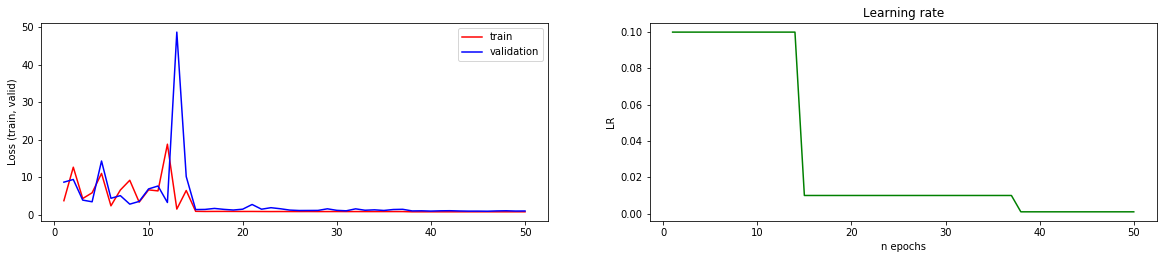

In [37]:
x = [i+1 for i in range(len(est.loss))]
plt.figure(figsize=(20,8))
plt.subplot(2, 2, 1)
plt.plot(x, est.loss, color='red')
plt.plot(x, est.valid, color='blue')
plt.ylabel('Loss (train, valid)')
plt.legend(['train', 'validation'])
plt.subplot(2, 2, 2)
plt.title('Learning rate')
plt.plot(x, est.lr, color='green')
plt.xlabel('n epochs')
plt.ylabel('LR');

Модель не остановилась, потому что там были маленькие колебания лосса, которые не видны на графике из-за большого выброса. Видно, что после 15 эпохи особенно ничего не меняется.

In [38]:
est.test(test_iterator, log_loss)

1.4484340279958992

## Model 2

In [39]:
class MyModel2(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, kernels, weights_matrix):
        super(MyModel2, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(weights_matrix)
        self.embedding.requires_grad = True
        
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x

In [40]:
est = Estimator(MyModel2, 50, len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
                kernels=[2,3,4,5],
                weights_matrix=weights_matrix, batch_size=32)

In [41]:
est.fit(train_iterator, valid_iterator)

Epoch    11: reducing learning rate of group 0 to 1.0000e-02.


Epoch    29: reducing learning rate of group 0 to 1.0000e-03.


Epoch    47: reducing learning rate of group 0 to 1.0000e-04.


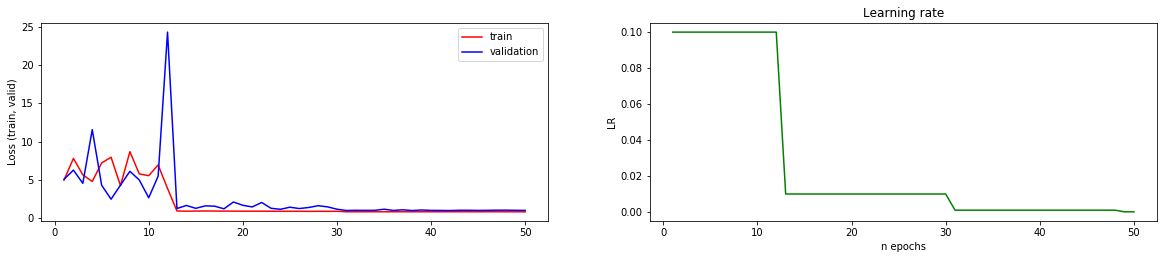

In [42]:
x = [i+1 for i in range(len(est.loss))]
plt.figure(figsize=(20,8))
plt.subplot(2, 2, 1)
plt.plot(x, est.loss, color='red')
plt.plot(x, est.valid, color='blue')
plt.ylabel('Loss (train, valid)')
plt.legend(['train', 'validation'])
plt.subplot(2, 2, 2)
plt.title('Learning rate')
plt.plot(x, est.lr, color='green')
plt.xlabel('n epochs')
plt.ylabel('LR');

Эта модель обучилась быстрее (раньше 15 эпохи), но тестовый лосс больше. Кажется, более плавное снижение в самом начале - лосс варьируется, но снижается, а не только прыгает (как в предыдущей)

In [43]:
est.test(test_iterator, log_loss)

1.5903268417464744

## Model 3

In [44]:
class MyModel3(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, kernels, weights_matrix):
        super(MyModel3, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x

In [45]:
est = Estimator(MyModel3, 50, len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
                kernels=[2,3,4,5],
                weights_matrix=weights_matrix, batch_size=32)

In [46]:
est.fit(train_iterator, valid_iterator)

Epoch     6: reducing learning rate of group 0 to 1.0000e-02.


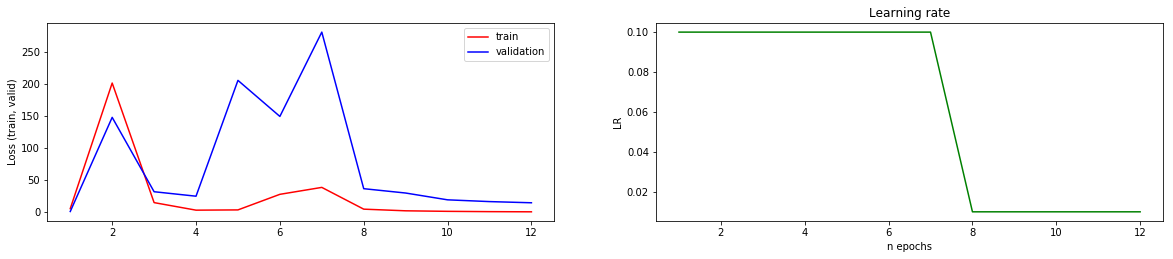

In [47]:
x = [i+1 for i in range(len(est.loss))]
plt.figure(figsize=(20,8))
plt.subplot(2, 2, 1)
plt.plot(x, est.loss, color='red')
plt.plot(x, est.valid, color='blue')
plt.ylabel('Loss (train, valid)')
plt.legend(['train', 'validation'])
plt.subplot(2, 2, 2)
plt.title('Learning rate')
plt.plot(x, est.lr, color='green')
plt.xlabel('n epochs')
plt.ylabel('LR');

In [48]:
est.test(test_iterator, log_loss)

22.392058873910045

Результат сильно хуже, чем в предыдущих моедях. Очень большой лосс, видно, что веса случайные и не так хорошо подгоняются (может быть, например, размер выборки). А предобученные вектора уже хорошо соответствуют действительности и лучше характеризуют тексты. К тому же, эта модель медленнее всего обучается. Можно сделать вывод, что здесь достаточно и проще использовать предобученные вектора, чем обучать эмбединги самим. Возможно, стоит взять большую размерность и попробовать с ней. 